### Plotting the time series for each pixel in each cluster

Objective : make interpretations easier

In [5]:
#import .txt file from data/reports

import os
import csv
import datetime
import re
import operator
import numpy as np

IN_DIR = "../results/reports"
IN_IMAGE_DIR = "../data/with_texture"
OUT_IMAGE_DIR = "../data/imagettes"
OUT_DIR = "../data/plots"

# Create the output folder if it doesn't exist
os.makedirs(OUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

#list of files in directory
files = os.listdir(IN_DIR)

# for file_name in files:
#     report_path = os.path.join(IN_DIR, file_name)

#     # Open the file
#     with open(report_path, "r") as f:
#         # Read the file
#         data = f.read()
#         # Split the file into lines
#         lines = data.split("\n")

file_name = files[0]
report_path = os.path.join(IN_DIR, file_name)

with open(report_path, "r") as f:
    # Read the file
    data = f.read()
    # Split the file into lines
    lines = data.split("\n")

coord = lines[3][8:].replace("(", "").replace(")", "").replace(",", " ").split()
coord = tuple(list(map(int, coord)))

#concat all lines into one string
data = "".join(lines[7:])[8:]
data = list(map(int,data.replace("[", "").replace("]", "").replace(",", " ").split()))
data = np.array(data).reshape(coord[2]-coord[0], coord[3]-coord[1])

print(data)

[[1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2]
 [2 2 2 2 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 1 1 1 1 2 0 0 0 0 0 0 0 0 0 2 2 2]
 [2 2 0 0 0 0 2 2 2 2 2 2 2 2 2 1 1 1 2 2]
 [2 2 1 1 1 1 1 1 1 1 0 0 0 2 2 2 2 0 0 0]
 [0 0 0 0 0

In [6]:
import rasterio
from rasterio.windows import Window
from time import sleep
from progress.bar import Bar

def crop_images(folder_path, coordinates, output_folder):
    """
    Crop all images in the specified folder using the given coordinates,
    and save the cropped images to the specified output folder.

    Args:
    - folder_path: The path to the folder containing images.
    - coordinates: A tuple containing the left, upper, right, and lower coordinates of the cropping box.
    - output_folder: The path to the folder where cropped images will be saved.
    """
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Filter out non-image files
    image_files = [f for f in files if f.endswith(('.tif', '.tiff'))]

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Loop through each image file
    with Bar('Cropping images', fill='#', suffix='%(percent).1f%% - %(eta)ds') as bar:
        for image_name in image_files:
            # Open the image file
            image_path = os.path.join(folder_path, image_name)
            with rasterio.open(image_path) as src:
                # Read the TIFF image
                img = src.read()

                # Get the metadata for the image
                meta = src.meta.copy()

                # Calculate the window to crop
                left, upper, right, lower = coordinates
                window = Window.from_slices((upper, lower), (left, right))

                # Crop the image using the specified window
                cropped_img = src.read(window=window)

                # Update metadata with new height and width
                meta['height'], meta['width'] = cropped_img.shape[-2], cropped_img.shape[-1]

                # Construct the output file path
                output_file_path = os.path.join(output_folder, f"{image_name[29:]}")

                # Write the cropped image to the output folder
                with rasterio.open(output_file_path, 'w', **meta) as dst:
                    dst.write(cropped_img)
                sleep(0.02)
                bar.next()

In [7]:
crop_images(IN_IMAGE_DIR, coord, OUT_IMAGE_DIR)

In [8]:
# for all images stack them into a 3D array (n_images, height, width) for each band

files_images = os.listdir(OUT_IMAGE_DIR)

# scrop the first characters of the file name
files_images = sorted(files_images)

files_images = files_images[:22] + files_images[23:]

print(len(files_images))

140


In [9]:
bands = []
for b in range(1,7):
    images = []
    for image_name in files_images:
        image_path = os.path.join(OUT_IMAGE_DIR, image_name)
        with rasterio.open(image_path) as src:
            img = src.read(b)
            images.append(img)
    bands.append(np.array(images))
bands.append((bands[0]-bands[1])/(bands[0]+bands[1]))
bands.append(((bands[2]-bands[0])/(bands[2]+bands[0])))
bands = np.array(bands)


/tmp/ipykernel_267398/2873924561.py:10: RuntimeWarning: invalid value encountered in divide
  bands.append((bands[0]-bands[1])/(bands[0]+bands[1]))
/tmp/ipykernel_267398/2873924561.py:11: RuntimeWarning: invalid value encountered in divide
  bands.append(((bands[2]-bands[0])/(bands[2]+bands[0])))


In [10]:
bands.shape

(8, 140, 20, 50)

In [11]:
c = 0
plots_cluster = []
n_bands = bands.shape[0]

for b in range(n_bands):
    plots_band = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i,j] == c:
                plots_band.append(bands[b,:,j,i])
    plots_cluster.append(plots_band)
plots_cluster = np.array(plots_cluster)


In [12]:
clusters = np.unique(data)


plots = []
for c in clusters:
    plots_cluster = []
    for b in range(n_bands):
        plots_band = []
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if data[i,j] == c:
                    plots_band.append(bands[b,:,j,i])
        plots_cluster.append(plots_band)
    plots_cluster = np.array(plots_cluster)
    plots.append(plots_cluster)

In [13]:
plots[0].shape

(8, 501, 140)

In [14]:
plots[0].shape[1]

501

In [15]:
legend_clusters = [f"{t} for cluster {c}" for t in ["Mean", "Std"] for c in range(len(plots))]
print(legend_clusters)


['Mean for cluster 0', 'Mean for cluster 1', 'Mean for cluster 2', 'Std for cluster 0', 'Std for cluster 1', 'Std for cluster 2']


(8, 3, 140)


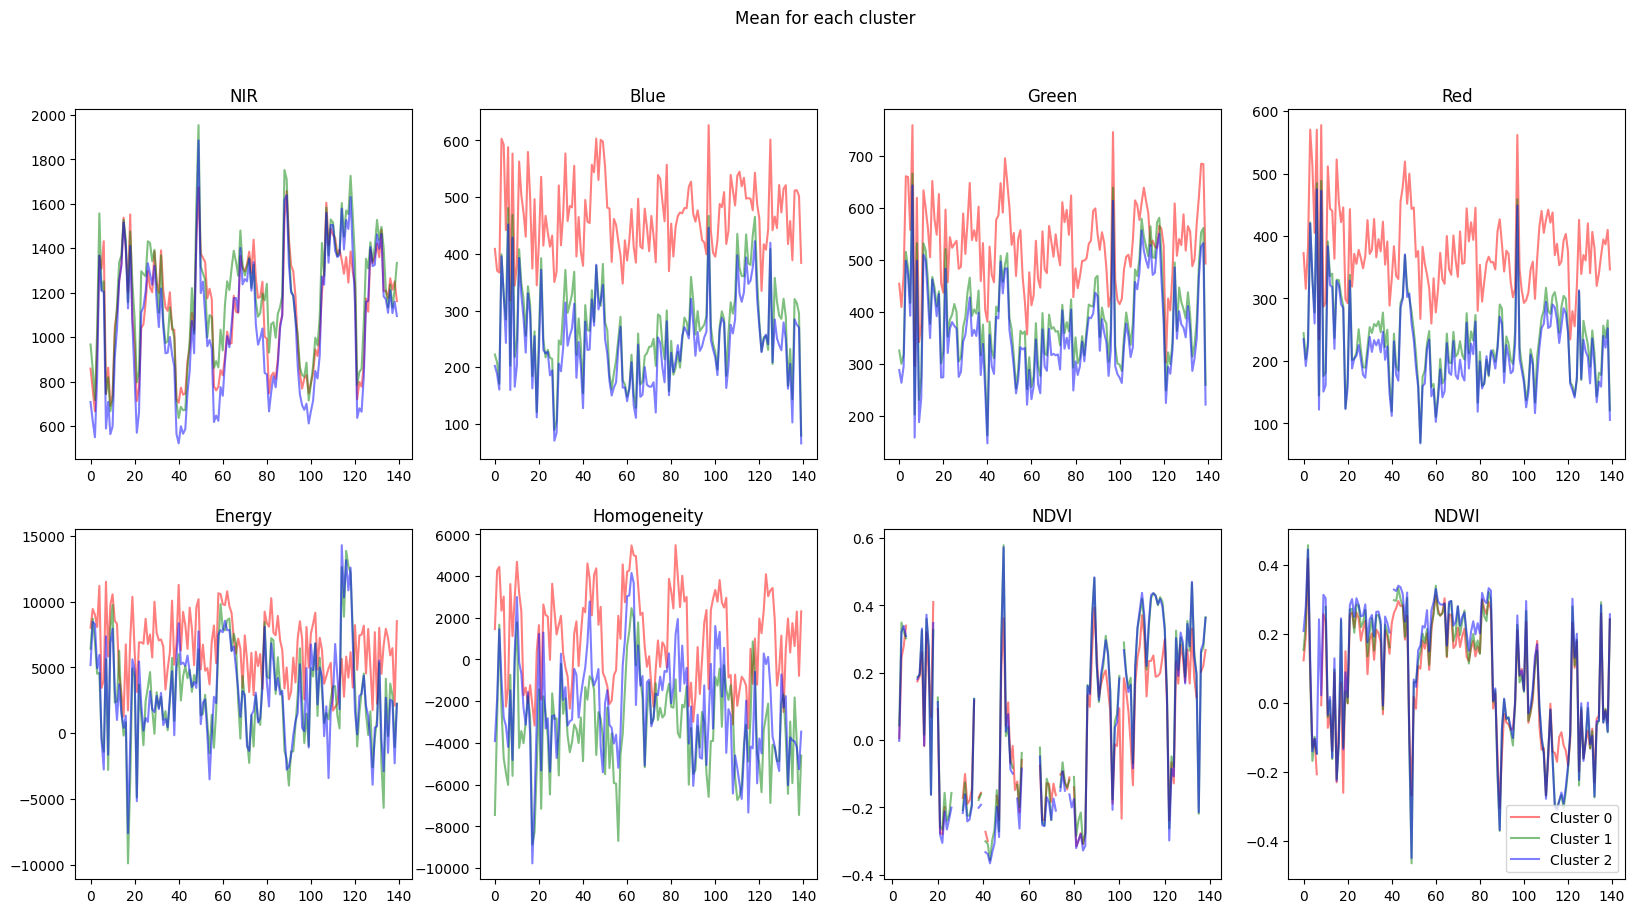

In [19]:
from math import sqrt

mean_plots = []
# std_plots = []
for b in range(n_bands):
    mean_plots_band = []
    # std_plots_band = []
    for c in range(len(plots)):
        mean_plots_band.append(np.mean(plots[c][b], axis=0))
        # std_plots_band.append(np.std(plots[c][b], axis=0))
    mean_plots.append(mean_plots_band)
    # std_plots.append(std_plots_band)

mean_plots = np.array(mean_plots)
# std_plots = np.array(std_plots)

print(mean_plots.shape)

import matplotlib.pyplot as plt

band_names = ["NIR", "Blue", "Green", "Red", "Energy", "Homogeneity", "NDVI", "NDWI"]
color_curve = ["r", "g", "b", "orange"]

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        for c in range(len(plots)):
            ax[i, j].plot(mean_plots[4*i+j,c], color = color_curve[c], alpha=0.5)
            # Z = 1.96/sqrt(plots[c].shape[1])
            # ax[i, j].fill_between(range(0, mean_plots.shape[2]), mean_plots[4*i+j,c] - std_plots[4*i+j,c], mean_plots[4*i+j,c] + std_plots[4*i+j,c], alpha=0.2)
            ax[i, j].set_title(band_names[4*i+j])
# add legend with the cluster number
# legend_clusters = [f"{t} for cluster {c}" for c in range(len(plots)) for t in ["Mean", "Std"]]
legend_clusters = [f"Cluster {c}" for c in range(len(plots))]
ax[1, 3].legend(legend_clusters, loc="lower right")
plt.suptitle("Mean for each cluster")

# Save the plot to a file
output_file_path = os.path.join(OUT_DIR, file_name[:-4] + f"_cluster_all.png")
plt.savefig(output_file_path)
            
plt.show()



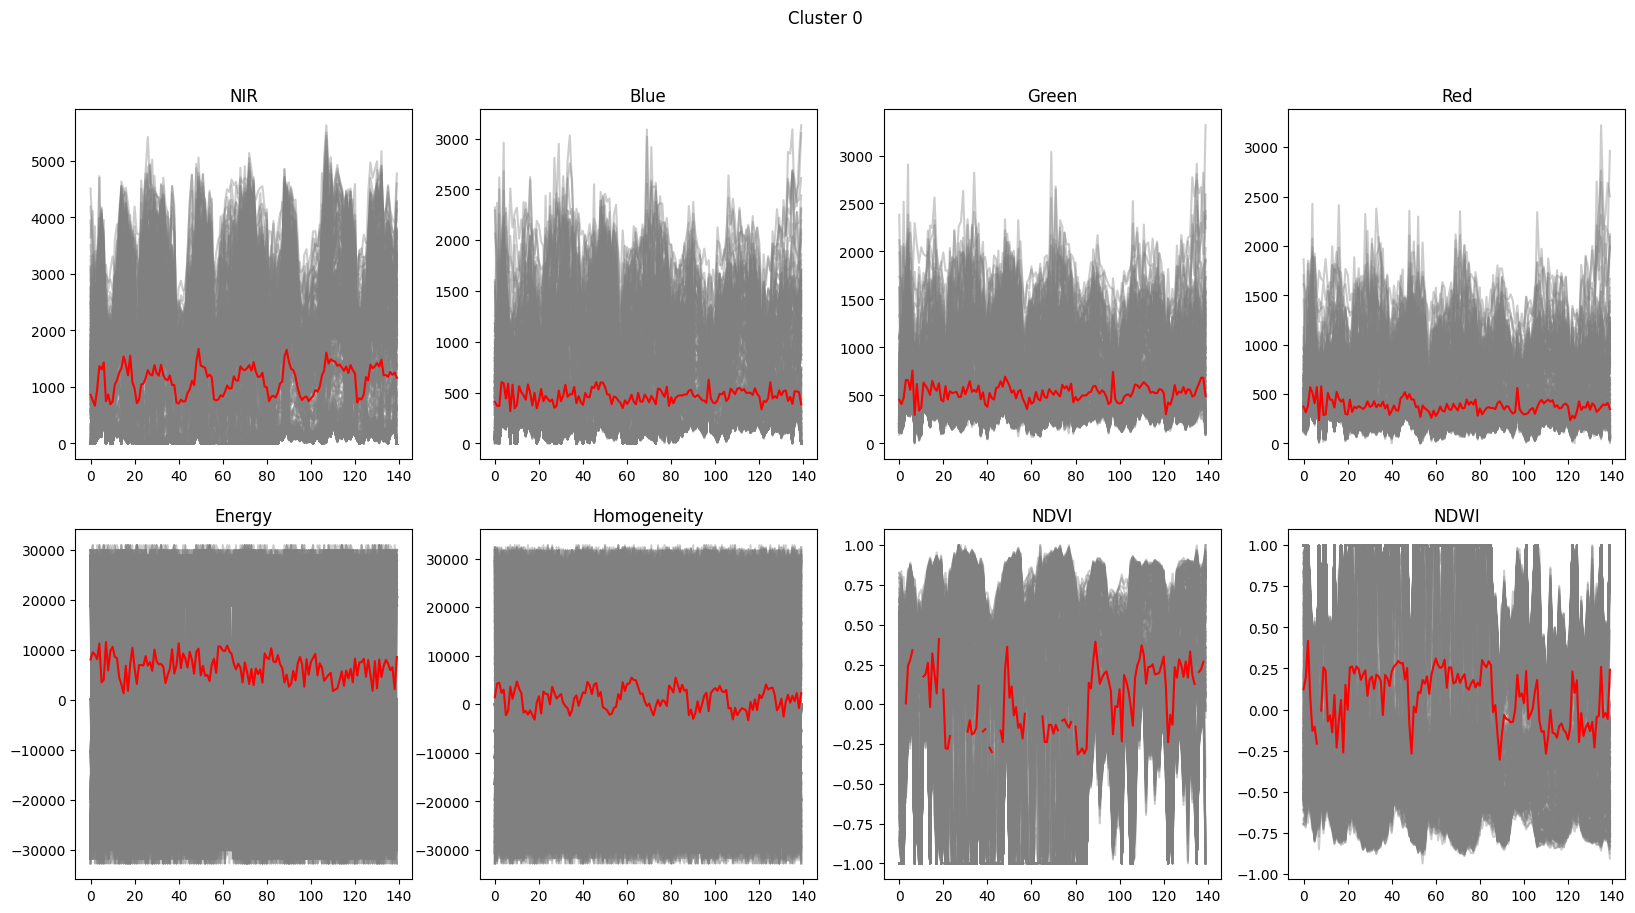

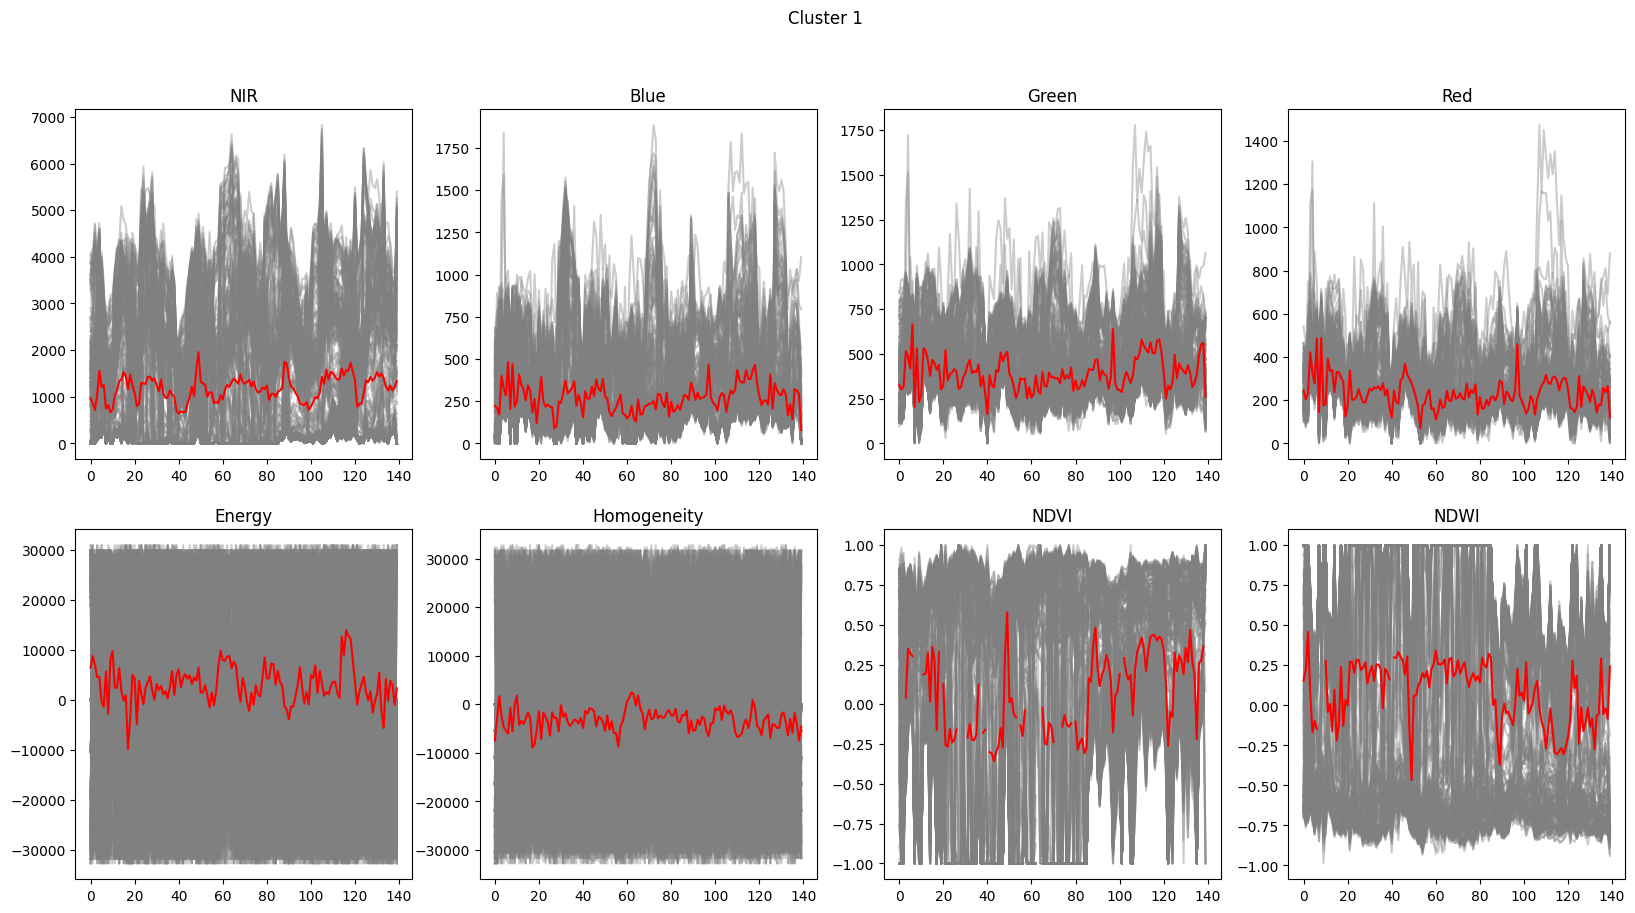

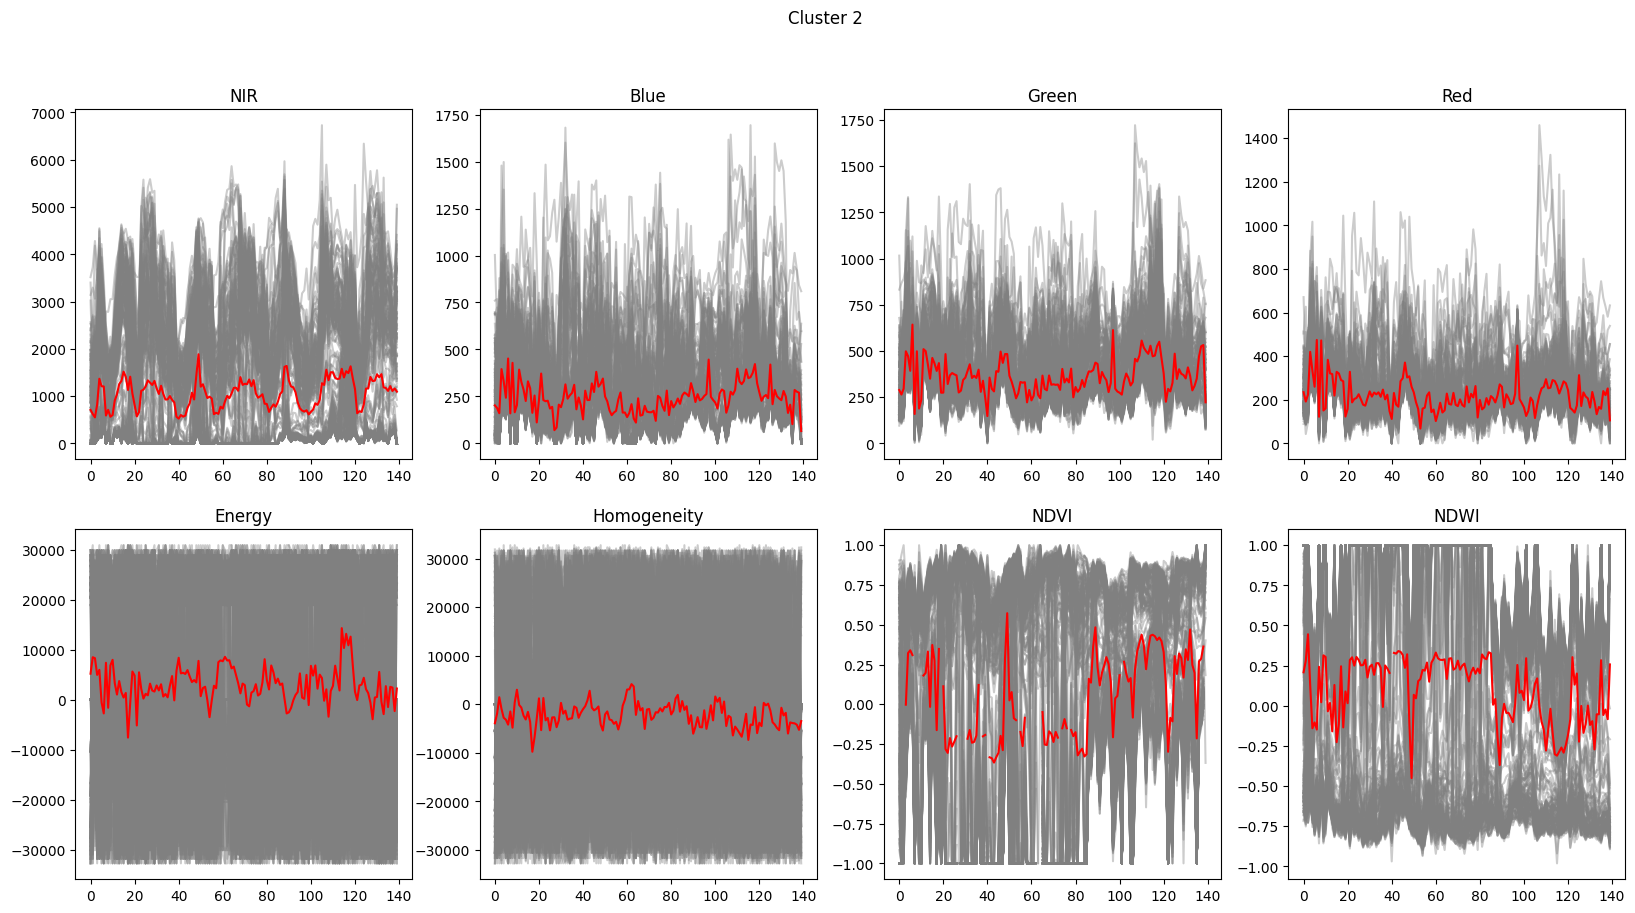

In [17]:
# for each cluster, plot the mean and all the time series of each band

import matplotlib.pyplot as plt

for c in range(len(plots)):
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    ax = ax.ravel()
    for b in range(n_bands):
        ax[b].plot(plots[c][b].T, color='grey', alpha=0.4)
        ax[b].plot(np.mean(plots[c][b], axis=0), color='red')
        ax[b].set_title(band_names[b])
    plt.suptitle(f"Cluster {c}")

    # Save the plot to a file
    output_file_path = os.path.join(OUT_DIR, file_name[:-4] + f"_cluster_{c}.png")
    plt.savefig(output_file_path)

    plt.show()
